# From Docplex to QUBO representation 

The Decision Optimization CPLEX modeling for python ([DOCPLEX](https://pypi.org/project/docplex/)) is a library that allows smooth prototyping for optimization problems. Here, we present the converter ```FromDocplex2IsingModel``` that translates the DOCPLEX optimization models into its OpenQAOA [QUBO](https://en.wikipedia.org/wiki/Quadratic_unconstrained_binary_optimization#Connection_to_Ising_models) representation. In general, problems in the form of [quadratic programming](https://en.wikipedia.org/wiki/Quadratic_programming) can be encoded using QUBOs. The three ingredints of an optimization model are the objective function, the equality constraints, and the inequality constraints. 

In this example, we show the solution of:

    1. A basic optimization model

    2. The Portfolio optimization problem 

    3. The Bin Packing problem


In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from docplex.mp.model import Model

from openqaoa.workflows.optimizer import QAOA
from openqaoa.problems.converters import FromDocplex2IsingModel
from openqaoa.devices import create_device


## 1) A basic optimization problem 

As we mention before, a basic quadratic programming problem includes the cost function, the equality constraints, and the inequality constraints. Imagine we want to minimize the follwing objective function $f(x)$

$$f(\textbf{x}) = x_0 + 3 x_0 x_1 + x_0 x2 - 5 x_4 x_2 + 3 x_4 x_3 + 3 x_4 $$

subject to the equality constraint

$$x_0 + 3 x_1 + 2 x_4 = 3,$$

and the inequality constraint:

$$x_2 + 3 x_3 + 2 x_4 \ge 3.$$

First, we represent the problem using `docplex` and then we translate it into its QUBO representation. Once, we have the QUBO we can use QAOA from OpenQAOA to solve it. 

In [2]:
mdl = Model("Basic Problem")

Adding the binary variables of the problem

In [3]:
n_vars = 5 # number of variables
x = mdl.binary_var_list(n_vars, name="x") # variables

- 1 Adding the objective function

In [4]:
obj_func = x[0] + 3 * x[0] * x[1] + x[0] * x[2] - 5 * x[4] * x[2] + 3 * x[4] * x[3] + 3 * x[4]
mdl.minimize(obj_func)

- 2. Adding equality constraints 

In [5]:
mdl.add_constraint(x[0] + 3 * x[1] + 2 * x[4] == 3)

docplex.mp.LinearConstraint[](x_0+3x_1+2x_4,EQ,3)

- 3. Adding inequality constraints

In [6]:
mdl.add_constraint(x[2] + 3 * x[3] + 2 * x[4] >= 3)
print(mdl.prettyprint())

// This file has been generated by DOcplex
// model name is: Basic Problem
// var contrainer section
dvar bool x[5];

minimize
 x_0 + 3 x_4 [ 3 x_0*x_1 + x_0*x_2 - 5 x_2*x_4 + 3 x_3*x_4 ];
 
subject to {
 x_0 + 3 x_1 + 2 x_4 == 3;
 x_2 + 3 x_3 + 2 x_4 >= 3;

}
None


### 1.1 Solving the problem using OpenQAOA

In Open exist the class `FromDocplex2IsingModel`, to covenrt the Docplex model into a qubo representation that is the imput from the object OpenQAOA

In [7]:
qubo = FromDocplex2IsingModel(mdl) # Converting the Docplex model into its qubo representation
ising_encoding = qubo.ising_model # Ising encoding of the QUBO problem 
pd.DataFrame(ising_encoding.asdict())

,terms,weights,constant,_n
0,"[0, 1]",26.25,181.0,7
1,"[0, 2]",0.25,181.0,7
2,"[2, 4]",15.75,181.0,7
3,"[3, 4]",51.75,181.0,7
4,"[0, 4]",17.00,181.0,7
5,"[1, 4]",51.00,181.0,7
6,"[2, 3]",25.50,181.0,7
7,"[2, 5]",-8.50,181.0,7
8,"[2, 6]",-17.00,181.0,7
9,"[3, 5]",-25.50,181.0,7


Using the methods from Openqaoa is generate a device in this case the model use the qiskit backend

In [8]:
device = create_device("local", 'qiskit.qasm_simulator')

Init the method QAOA for use the quantum algorithm with the device and consider some properties a: number of shots, seed, the p value, the init type, and the variational params

In [9]:
qaoa = QAOA(device)
qaoa.set_backend_properties(n_shots=20, seed_simulator=1)
qaoa.set_circuit_properties(p=1, init_type="custom", variational_params_dict={"betas":[0.01*np.pi],"gammas":[0.01*np.pi]})
qaoa.compile(ising_encoding)
qaoa.optimize()
pd.DataFrame(qaoa.results.lowest_cost_bitstrings(5))


,solutions_bitstrings,bitstrings_energies,probabilities
0,1001101,7.0,0.10
1,0111001,17.0,0.05
2,1101000,21.0,0.05
3,1001110,24.0,0.05
4,0010110,32.0,0.05


The 5 best solutions of the problem with their respective energies and probabilites using QAOA

From the solution we can see that we obtain three solutions `0111010`, `1010100`, and `0101000` and with the minimum energy `0`. this can be confirmed  using the `ground_state_hamiltonian` method.

In [10]:
from openqaoa.utilities import ground_state_hamiltonian
correct_solution = ground_state_hamiltonian(qaoa.cost_hamil)
correct_solution

(0.0, ['0101000', '1010100', '0111010'])

### 1.2 Solution using DOCPLEX

Solving the problem classically is possible using DOCPLEX, this is an excellent option to test the solution of our quantum solver.

In [11]:
mdl_qubo = qubo.qubo_docplex # docplex QUBO model
sol = mdl_qubo.solve()
mdl_qubo.print_solution(print_zeros=True)

objective: 0.000
  x_0=0
  x_1=1
  x_2=0
  x_3=1
  x_4=0
  slack_C1_0=0
  slack_C1_1=0


## 2. The Portfolio optimization problem 

Modern [Portfolio optimization](https://en.wikipedia.org/wiki/Portfolio_optimization) is a problem that involves finding the best set of assets that maximize the profit of those assets minimizing the risk of the investment. Usually, the risks are associated with changes in the market that makes the set of assets lose its value, and therefore investors lose part of their budget. 

This problem is known to be an NP-hard problem and its objective function is given by 

<div class="alert alert-block alert-success">
$$\max_{x} : \mu^{T} x-q x^{T} \Sigma x$$
</div>

Subject to: 
    $$\sum_{i=1}^{N} c_i x_i = B$$

where:
- $N$ represents the number of assets
- $x \in\{0,1\}^{N}$ denotes the vector of binary decision variables, which indicate which assets to pick ( $\left.x[i]=1\right)$ and which not to pick $(x[i]=0)$,
- $\mu \in R^{n}$ defines the expected returns for the assets,
- $\Sigma \in R^{n \times n}$ specifies the covariances between the assets,
- $q>0$ controls the risk aversion of the decision maker,
- $c_i$ is the cost of investing in the ith asset
- $B$ denotes the budget, i.e., the total investment..

#### Generate the data

To simplify the problem, it is used a random function to generate the predictions the expected return for 10 assets during 15 days. Additionally, the cost of investment in each assets (c<sub>i</sub>) is set to 1.

In [12]:
np.random.seed(1)
num_assets = 10
num_days = 15
q = 0.01 # Risk aversion
Budget = 5
c = num_assets * [1] # Cost of buying the different assets c_i
# Creating a random history of the forcasting for the expected return 
hist_exp = (1 - 2 * np.random.rand(num_assets)).reshape(-1,1) * (np.array([np.arange(num_days) for i in range(num_assets)]) + np.random.randint(10)) + (1 - 2 * np.random.rand(num_assets,  num_days)) 
mu = hist_exp.mean(axis=1) # mean expected return over the 10 days
sigma = np.cov(hist_exp) # Covariance matrix (Sigma) for the risk term of the cost function

<IPython.core.display.Javascript object>


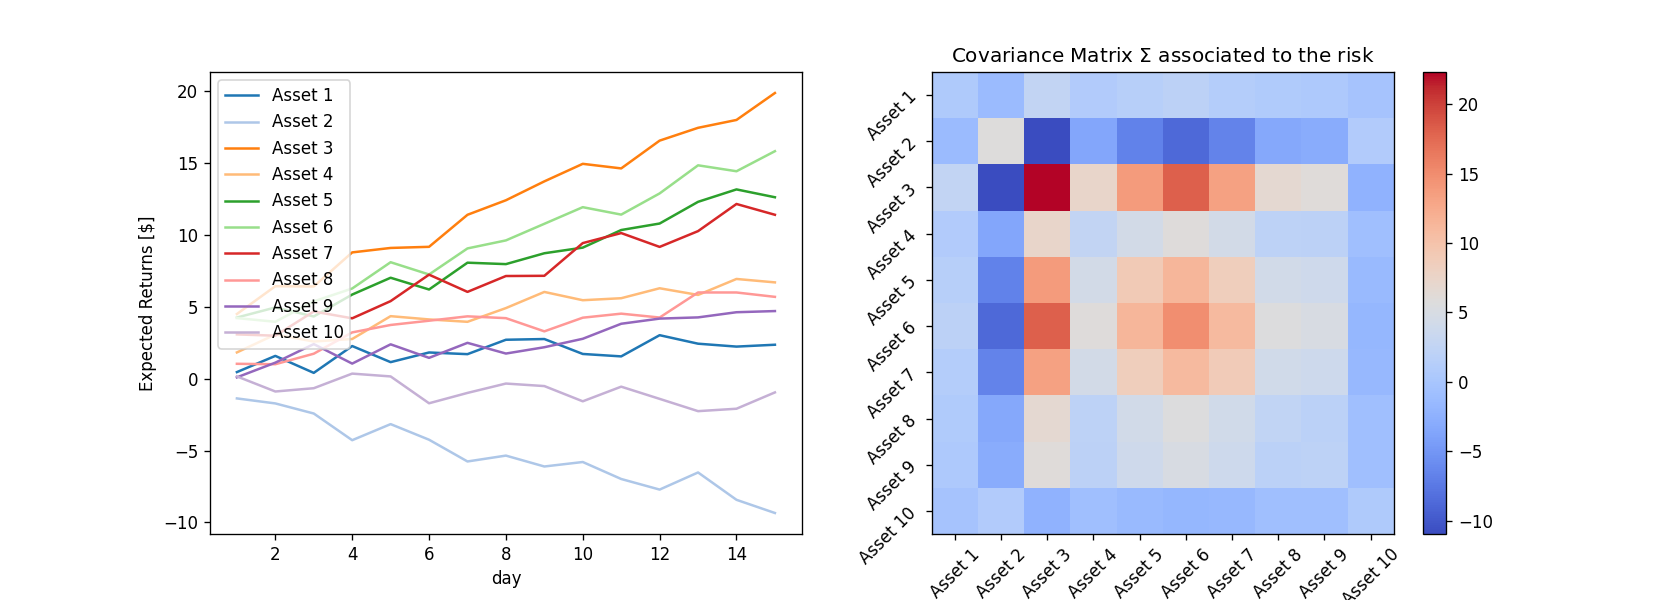

Text(0.5, 1.0, 'Covariance Matrix $\\Sigma$ associated to the risk')

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))
colors = plt.cm.tab20(range(20))
for i in range(num_assets):
    ax[0].plot(range(1, num_days+1), hist_exp[i], color=colors[i])
ax[0].set_xlabel("day")
ax[0].set_ylabel("Expected Returns [$]")
ax[0].legend([f"Asset {i}" for i in range(1, num_assets+1)])
im = ax[1].imshow(sigma, cmap="coolwarm")
fig.colorbar(im)
ax[1].set_yticks(range(num_assets))
ax[1].set_xticks(range(num_assets))
ax[1].set_xticklabels([f"Asset {i}" for i in range(1, num_assets+1)], rotation=45)
ax[1].set_yticklabels([f"Asset {i}" for i in range(1, num_assets+1)], rotation=45)
ax[1].set_title(r"Covariance Matrix $\Sigma$ associated to the risk")

### 2.1 Solving the problem using OpenQAOA


#### Obtain the Quadratic problem from docplex

Once it is obtained the data for the portfolio optmization problem, the next step is to translate it into a docplex model. Considering the above data of expected returns, covariances, risk factor, and budget the docplex model to solve it is given by:

In [14]:
mdl = Model('Portfolio Optimization')

# Binary set of variables that represent the stocks
x = np.array(mdl.binary_var_list(num_assets, name="asset")) # x vector in numpy array for matrix multiplication

# Portfolio optimization function
objective_function = mu @ x - x.T @ sigma @ x
mdl.maximize(objective_function)

# Budget constraint
mdl.add_constraint(c @ x == Budget, ctname='budget')

# Printing the docplex model
mdl.prettyprint()

// This file has been generated by DOcplex
// model name is: Portfolio Optimization
// var contrainer section
dvar bool asset[10];

maximize
 1.881355 asset_0 - 5.283574 asset_1 + 12.236010 asset_2 + 4.699490 asset_3
 + 8.388273 asset_4 + 9.738609 asset_5 + 7.370289 asset_6 + 3.824391 asset_7
 + 2.622312 asset_8 - 0.885102 asset_9 [ - 0.612974 asset_0^2
 + 2.666327 asset_0*asset_1 - 5.200267 asset_0*asset_2
 - 1.784143 asset_0*asset_3 - 2.990688 asset_0*asset_4
 - 3.865797 asset_0*asset_5 - 2.501242 asset_0*asset_6
 - 1.504942 asset_0*asset_7 - 0.984580 asset_0*asset_8
 + 0.437093 asset_0*asset_9 - 5.766480 asset_1^2 + 21.930022 asset_1*asset_2
 + 7.073813 asset_1*asset_3 + 13.507653 asset_1*asset_4
 + 17.473295 asset_1*asset_5 + 13.144398 asset_1*asset_6
 + 6.706427 asset_1*asset_7 + 5.917903 asset_1*asset_8
 - 1.979177 asset_1*asset_9 - 22.322708 asset_2^2 - 14.491830 asset_2*asset_3
 - 27.657138 asset_2*asset_4 - 36.081466 asset_2*asset_5
 - 26.615248 asset_2*asset_6 - 13.368734 ass

#### Convert the model into a Ising Hamiltonian

The method `FromDocplex2IsingModel` from OpenQAOA converts the docplex representation of the problem to its QUBO representation in Ising encoding (-1, 1). From there, it is only required setting the QAOA model and solve the QUBO.

In [15]:
qubo_po = FromDocplex2IsingModel(mdl) # Converting the Docplex model of portfolio into its qubo representation
ising_encoding_po = qubo_po.ising_model # Ising encoding of the QUBO problem for portfolio optimization
mdl_qubo_docplex = qubo_po.qubo_docplex

Using the qiskit backend and 128 shots with a p value equals to 2, with  betas and gammas  of $0.01 * \pi$ 

In [16]:
device = create_device("local", 'qiskit.qasm_simulator')
qaoa_po = QAOA(device)
qaoa_po.set_backend_properties(n_shots=128, seed_simulator=1)
qaoa_po.set_circuit_properties(p=2, init_type="custom", variational_params_dict={"betas":2*[0.01*np.pi],"gammas":2*[0.01*np.pi]})
qaoa_po.compile(ising_encoding_po)
qaoa_po.optimize()
qaoa_po_dict = qaoa_po.results.lowest_cost_bitstrings(5)
pd.DataFrame(qaoa_po_dict)

,solutions_bitstrings,bitstrings_energies,probabilities
0,1101000101,-2.472965,0.015625
1,1101001001,-2.299722,0.007812
2,1100100101,-2.160815,0.007812
3,1100100011,-1.820697,0.007812
4,1100001101,-1.770147,0.007812


Chek the correct answer using the ground_state_hamiltonian.

In [17]:
from openqaoa.utilities import ground_state_hamiltonian
sol = ground_state_hamiltonian(qaoa_po.cost_hamil)
sol

(-2.6042725099164272, ['1101100001'])

### 2.2 Solution using DOCPLEX

Additionally, a QUBO representation model in docplex format can be upload from `FromDocplex2IsingModel(mdl)` to solve the QUBO problem classically. This is convenient when the result from QAOA wants to be contrasted against classical optimizers.

In [18]:
mdl_qubo_po = qubo_po.qubo_docplex # docplex QUBO model
sol_po_docplex = mdl_qubo_po.solve()
sol_po = {i.name: int(sol_po_docplex.get_value(i)) for i in mdl_qubo_po.iter_binary_vars()}
sol_po

{'asset_0': 1,
 'asset_1': 1,
 'asset_2': 0,
 'asset_3': 1,
 'asset_4': 1,
 'asset_5': 0,
 'asset_6': 0,
 'asset_7': 0,
 'asset_8': 0,
 'asset_9': 1}

## 3. The Bin Packing problem 

The [bin packing problem](https://en.wikipedia.org/wiki/Bin_packing_problem) is an optimization problem where given a number of items with an assigned weight, we look at the best way to group the items minimizing the number of bins or containers needed to store them. The restriction, in this case, is the capacity of the bins which cannot surpass a certain weight. This problem has many real applications in areas such as loading trucks with a weight restriction, filling up containers, and FPGA semiconductors chip design. 

In terms of complexity, the bin packing problem is an NP-hard problem. However, there are efficient algorithms that allow the arrangement of a large number of items. One of them is the first fit, which provides a fast but not optimal solution to the problem. 

For our problem, we will explore the solution to the bin packing problem, using a quantum computing representation in terms of quadratic unconstraint binary optimization (QUBO) and using the quantum approximation optimization (QAOA) algorithm. 

### Problem statement

minimize $$K = \sum_{j=1}^m y_j$$

subject to:

$$\sum_{i=1}^n s(i) x_{ij} \le B y_j \qquad  \forall \ j=1,...,m$$
$$\sum_{j=1}^m x_{ij} = 1  \qquad \forall \ i = 1, ..., n$$
$$x_{ij}\in  \{0,1\} \qquad \forall \ i=1,..,n \qquad j=1,..,m$$
$$y_{j}\in  \{0,1\} \qquad \forall \ j=1,..,m $$

- n is the number of items
- m is the number of bins
- $s(i)$ is the i-th item weight
- B is the maximum weight of the bin
- $x_{ij}$ is the variable that represent if the item i is in the bin j.
- $y_j$ is the variable that represent if bin j is used

#### Generate the data

In [19]:
np.random.seed(1)
num_items = 2 # number of items
num_bins = num_items # maximum number of bins
max_weight = 7 # max weight of a bin

weights = np.random.randint(1, max_weight, num_items) # Randomly picking the item weight

### 3.1 Solving the problem using QAOA

#### Obtaining the Docplex model

In [20]:
# Construct model using docplex
mdl = Model("BinPacking")

y = mdl.binary_var_list(num_bins, name="y") # list of variables that represent the bins
x =  mdl.binary_var_matrix(num_items, num_bins, "x") # variables that represent the items on the specific bin

objective = mdl.sum(y)

mdl.minimize(objective)

for i in range(num_items):
    # First set of constraints: the items must be in any bin
    mdl.add_constraint(mdl.sum(x[i, j] for j in range(num_bins)) == 1)
    
for j in range(num_bins):
    # Second set of constraints: weight constraints
    mdl.add_constraint(mdl.sum(weights[i] * x[i, j] for i in range(num_items)) <= max_weight * y[j])
mdl.prettyprint()

// This file has been generated by DOcplex
// model name is: BinPacking
// var contrainer section
dvar bool y[2];
dvar bool x[2][2];

minimize
 y_0 + y_1;
 
subject to {
 x_0_0 + x_0_1 == 1;
 x_1_0 + x_1_1 == 1;
 6 x_0_0 + 4 x_1_0 <= 7 y_0;
 6 x_0_1 + 4 x_1_1 <= 7 y_1;

}


In [21]:
qubo_bin = FromDocplex2IsingModel(mdl) # Converting the Docplex model of binpacking into its qubo representation
ising_encoding_bin = qubo_bin.ising_model # Ising encoding of the QUBO problem for binpacking problem
mdl_qubo_docplex_bin = qubo_bin.qubo_docplex
mdl_qubo_docplex_bin.prettyprint()

// This file has been generated by DOcplex
// model name is: Copy of Copy of BinPacking
// var contrainer section
dvar bool y[2];
dvar bool x[2][2];
dvar bool slack_C2[3];
dvar bool slack_C3[3];

// single vars section
dvar bool y_0;
dvar bool y_1;
dvar bool x_0_0;
dvar bool x_0_1;
dvar bool x_1_0;
dvar bool x_1_1;
dvar bool slack_C2_0;
dvar bool slack_C2_1;
dvar bool slack_C2_2;
dvar bool slack_C3_0;
dvar bool slack_C3_1;
dvar bool slack_C3_2;

minimize
 y_0 + y_1 - 6 x_0_0 - 6 x_0_1 - 6 x_1_0 - 6 x_1_1 [ 147 y_0^2 - 252 y_0*x_0_0
 - 168 y_0*x_1_0 - 42 y_0*slack_C2_0 - 84 y_0*slack_C2_1 - 168 y_0*slack_C2_2
 + 147 y_1^2 - 252 y_1*x_0_1 - 168 y_1*x_1_1 - 42 y_1*slack_C3_0
 - 84 y_1*slack_C3_1 - 168 y_1*slack_C3_2 + 111 x_0_0^2 + 6 x_0_0*x_0_1
 + 144 x_0_0*x_1_0 + 36 x_0_0*slack_C2_0 + 72 x_0_0*slack_C2_1
 + 144 x_0_0*slack_C2_2 + 111 x_0_1^2 + 144 x_0_1*x_1_1 + 36 x_0_1*slack_C3_0
 + 72 x_0_1*slack_C3_1 + 144 x_0_1*slack_C3_2 + 51 x_1_0^2 + 6 x_1_0*x_1_1
 + 24 x_1_0*slack_C2_0 + 48 x_1

Using the pyquil backend and 1024 shots with a p value equals to 3, with  betas and gammas  of $0.01 * \pi$ 

In [24]:
#device = create_device("local", 'qiskit.qasm_simulator')
device = create_device("local", 'pyquil.statevector_simulator')
qaoa_bin = QAOA(device)
qaoa_bin.set_backend_properties(n_shots=1024, seed_simulator=1)
rep = 3
qaoa_bin.set_circuit_properties(p=rep, init_type="custom", variational_params_dict={"betas":rep*[0.01*np.pi],"gammas":rep*[0.01*np.pi]})
qaoa_bin.compile(ising_encoding_bin)
qaoa_bin.optimize()

show the best 5 states for this binpacking problem

In [25]:
qaoa_bin_dict = qaoa_bin.results.lowest_cost_bitstrings(5)
pd.DataFrame(qaoa_bin_dict)

,solutions_bitstrings,bitstrings_energies,probabilities
0,111001100110,2.0,6.772599e-07
1,110110110100,2.0,6.772599e-07
2,100010110000,4.0,2.518399e-06
3,010100000100,4.0,1.779673e-05
4,101000100000,4.0,1.779673e-05


Chek the correct answer using the ground_state_hamiltonian and the 2 correct answer are in the best 5 best states.

In [27]:
sol = ground_state_hamiltonian(qaoa_bin.cost_hamil)
sol

(2.0, ['110110110100', '111001100110'])

### 2.2 Solution using DOCPLEX

In [23]:
mdl_qubo_bin = qubo_bin.qubo_docplex # docplex QUBO model
sol_bin_docplex = mdl_qubo_bin.solve()
sol_bin = {i.name: int(sol_bin_docplex.get_value(i)) for i in mdl_qubo_bin.iter_binary_vars()}
mdl_qubo_bin.print_solution(print_zeros=True)

objective: 2.000
  y_0=1
  y_1=1
  x_0_0=0
  x_0_1=1
  x_1_0=1
  x_1_1=0
  slack_C2_0=1
  slack_C2_1=1
  slack_C2_2=0
  slack_C3_0=1
  slack_C3_1=0
  slack_C3_2=0
